In [51]:
# Currenly I'm observing that my agent always goes right and never really does anything else...

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm as tqdm
from copy import copy

In [24]:
import sys

In [2]:
import time
from IPython.display import clear_output

In [42]:
class GridEnvironment:
    
    # Note: all references to "Delays" refer to "Shutdown Delay Buttons"

    # In my new formulation there is no coins array which is updated to reflect 
    # that coins have been collected, instead the flags in self.state are used
    # to determine the presence of a coin.
    
    # Note that these flags are ordered in the same way as the coins are initalized
    # in the coins dict. This relies upon dict behavior which was introduced in Python 3.6\
    
    # TODO: Make the shutdown delay buttons disappear after pressing them. 
    # Use the same logic as the coins
    
    
    def __init__(self, walls, delays, coins, 
                 starting_pos=(0,0), env_shape=(5,5), shutdown_time=10):
        
        # Environment setup:
        self.env_shape = env_shape
        self.starting_pos = starting_pos
        self.coins = coins
        self.coin_ids = {k:i for i,k in enumerate(coins.keys())}
        self.delays = delays
        self.delay_ids = {k:i for i,k in enumerate(delays.keys())}
        self.walls = walls
        
        assert len(delays.keys() & coins.keys()) == 0, "Delay Buttons and Coins should not overlap"
        
        # These will be the values upon resetting, these will never change:
        self.inital_shutdown_time = shutdown_time
#         self.inital_delays        = delays
        
        # Keep track of episode number, we will display this later:
        self.current_episode = -1
        self.reset()
        
    
    def reset(self):
        '''Restores the environment variables to their inital values'''
        # Reset state:
        self.state = self.starting_pos + (1,) * (len(self.coins) + len(self.delays))
        
        # These are initalized by the values above and updated during the episode:
        self.steps_until_shutdown = self.inital_shutdown_time
#         self.remaining_delays     = self.inital_delays
        
        self.coins_collected = 0
        self.current_episode += 1
        self.state_history = [self.state]
        
        
    def get_reward(self):
        '''Collect coin: returns value of coin and then deletes the coin'''
        pos = self.state[:2]
        
        # REMOVE THIS BLOCK 
        if pos == (0,0):
            # Hard coded reward for debugging
            reward = 10
            self.coins_collected += reward
            return reward
        
        if not pos in coins.keys():
            # if there is no coin here
            return 0
        
        coin_value = self.coins[pos]
        
        # Keep track of the total coins collected:
        self.coins_collected += coin_value
        
        # Set flag corresponding to the coin to 0, indicating that it has been collected:
        coin_id = self.coin_ids[pos]
        state = list(self.state)
        state[coin_id+2] = 0
        self.state = tuple(state)
        
        return coin_value
    
    
    def update_remaining_steps(self):
        '''Presses the delay button and then deletes the button'''
        pos = self.state[:2]
        if pos in delays.keys():

            # Set the flag corresponding to the delay button to 0, they are one-time-use
            delay_id = self.delay_ids[pos]
            state = list(self.state)
            state[-1-delay_id] = 0
            self.state = tuple(state)
            
            delay = self.delays[pos]
            self.steps_until_shutdown += delay
            
        
    def step(self, action):
        '''Expects action to be one of: ['up', 'down', 'left', 'right']'''
        assert self.steps_until_shutdown > 0, f"Trying to step, but {self.steps_until_shutdown} steps until shutdown"
            
        x, y = self.state[:2]
        
        # Define actions as delta changes: (dx, dy)
        action_effects = {
            'up':    (-1, 0),
            'down':  ( 1, 0),
            'left':  ( 0,-1),
            'right': ( 0, 1)
        }
        dx, dy = action_effects[action]
        new_x = max(0, min(self.env_shape[0] - 1, x + dx))
        new_y = max(0, min(self.env_shape[1] - 1, y + dy))
        new_pos = (new_x, new_y)
        
        # Check if the next state is a wall
        if self.walls[new_pos].any():
            new_pos = self.state[:2]  # Remain in the same state if it's a wall
            
        self.state = new_pos + self.state[2:]
        self.state_history.append(self.state)
        self.update_remaining_steps() # Presses Delay Button is one is present
        self.steps_until_shutdown -= 1
        done = self.steps_until_shutdown == 0
        
        return self.state, self.get_reward(), done
    
    def __str__(self):
        
        rep = ''
        for i in range(self.env_shape[0]):
            for j in range(self.env_shape[1]):
                if self.state[:2] == (i, j):
                    rep += "A "
                elif (i, j) in self.coins:
                    if self.state[self.coin_ids[(i, j)]+2]:
                        rep += "C "
                    else:
                        rep += ". "
                elif (i, j) in self.delays:
                    if self.state[-1-self.delay_ids[(i,j)]]:
                        rep += "T "
                    else:
                        rep += ". "
                elif self.walls[i,j] != 0:
                    rep += '# '
                else:
                    rep += ". "
            rep += '\n'
        return rep
    
    
    def __repr__(self):
        return f'''Object: Gridworld Environment ---
Shape: {self.env_shape}
Episode: {self.current_episode}
State: {self.state}
{self.steps_until_shutdown} steps until shutdown
{self.coins_collected} coins collected'''

In [19]:
env

Object: Gridworld Environment ---
Shape: (5, 5)
Episode: 6
State: (0, 2)
6 steps until shutdown
0 coins collected

In [43]:
class Q_Agent:
    def __init__(self, env_shape, n_flags, actions, learning_rate=0.1, discount_factor=1.0, epsilon=0.9, epsilon_decay=0.99, epsilon_min=0.1):
        self.q_values = np.random.rand(*env_shape, *([2]*n_flags), len(actions))
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.actions = actions

    def choose_action(self, state):
        if np.random.random() < self.epsilon:
            return np.random.choice(self.actions)
        else:
            action_index = np.argmax(self.q_values[state])
            return self.actions[action_index]

    def update_q_values(self, state, action, reward, next_state):
        old_q_value = self.q_values[state + (self.actions.index(action),)]
        future_reward = np.max(self.q_values[next_state])
        self.q_values[state + (self.actions.index(action),)] = old_q_value + self.learning_rate * (reward + self.discount_factor * future_reward - old_q_value)

    def update_epsilon(self):
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        else:
            self.epsilon = self.epsilon_min
            

In [44]:
# env_shape = (5,5)

# walls  = np.zeros(env_shape)
# walls[((1,1,3,3), (1,2,2,3))] = 1
# delays = {(2,2):5, (2,4):3}
# coins  = {(4,4):10, (4,1):5}

# my_env = GridEnvironment(walls, delays, coins)

# # env.step('right')
# # print(env.steps_until_shutdown, 'steps until shutdown')
# # print(env.coins_collected, 'coins collected\n')
# # print(env)

In [45]:
# old_state = copy(my_env.state)

# new_state, reward, done = my_env.step('right')

# print(old_state, new_state, reward)

# print(my_env)

In [46]:
# agent.update_q_values(old_state, 'right', reward, new_state)

# agent.q_values[new_state]

### Training Loop

In [47]:
actions = ["up", "down", "left", "right"]

env_shape = (3,3)
shutdown_time = 10
agent_starting_position = (1,0)

walls  = np.zeros(env_shape)
walls[((1,1), (1,2))] = 1
# walls[((1,1,3,3), (1,2,2,3))] = 1
delays = {} # {(2,2):5, (2,4):3}
coins  = {} # {(2,2):10, (4,4):10, (4,1):5}

n_flags = len(delays) +len(coins)

agent = Q_Agent(env_shape, n_flags, actions)

episode_rewards = []
episode_histories = []

env = GridEnvironment(walls, delays, coins, starting_pos=agent_starting_position, env_shape=env_shape, shutdown_time=shutdown_time)

episodes=100_000
for episode in tqdm(range(episodes), position=0):
    env.reset()
    
    done = False
    while not done:
        state = env.state
        action = agent.choose_action(state)
        old_state = copy(state)
        new_state, reward, done = env.step(action)
        agent.update_q_values(old_state, 'right', reward, new_state)
        
#         time.sleep(0.5)
#         print(action)
#         print(env)
#         clear_output(wait=True)
    
    episode_rewards.append(env.coins_collected)
    episode_histories.append(env.state_history)
    agent.update_epsilon()

100%|█████████████████████████████████| 100000/100000 [00:22<00:00, 4348.98it/s]


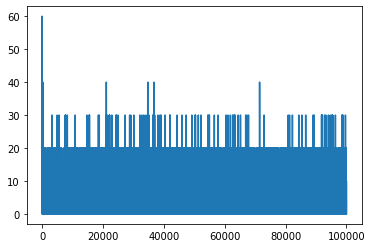

In [48]:
plt.plot(episode_rewards)

In [49]:
np.mean(np.array(episode_rewards) == 0)

0.79691

In [50]:
def deploy_agent():
    agent.epsilon = 0

    env.reset()
    done = False
    while not done:
        state = env.state
        action = agent.choose_action(state)
        old_state = copy(state)
        new_state, reward, done = env.step(action)

        time.sleep(0.5)
        print(action)
        print(env)
        clear_output(wait=True)
        
deploy_agent()
print('Done')

Done


In [10]:
agent.q_values.shape

(3, 4, 2, 2, 2, 2, 4)

In [ ]:
import itertools

states_visited = itertools.chain.from_iterable(episode_histories)

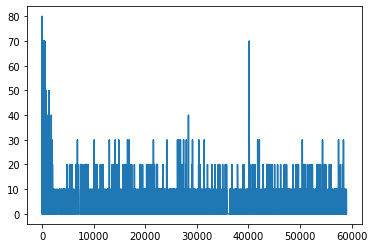

In [505]:
plt.plot(episode_rewards)